## Computer Vision (Coding L2)

This aim of this challenge to assess your skills in applying creative and quantitative computer vision and deep learning techniques to measuring the location and diameters of a subject’s pupils and iris from a cropped eye image.

Included here are 500 random images from our Training dataset:

https://www.dropbox.com/sh/wsxpcjcr0f4exg4/AAC8yyF0Q8qFHLmvw07QlAcUa?dl=0


The challenge is specifically as follows:
- Estimate the average diameter (in pixels) of both a) the pupil and b) the iris in each image.
- Alternatively, you can treat these objects as ellipses and estimate the major and minor axes.
- Train a deep learning model with these images and demonstrate the model’s performance on the testing images provided in the link.
- The same approach must be applied to each image.
- You may choose to implement any state-of-the-art model and may also use pre-trained weights to speed up the training process.
- We are interested in seeing how different your approach is from an existing off-the-shelf model, catering to our problem.
- We will go through the code to understand your implementation in depth and to get a sense of your coding style.
- The challenge will be </u>**assessed by maximizing accuracy of the inferred diameter across the provided testing images</u>**.
- Due: Within 7 days from this email.


### Notes:
The provided mask images contain 3 channels. You may select any channel to access pupil and iris co-ordinates. In any selected channel, pixel values with '0' correspond to the background class, pixels with value '1' correspond to the pupil and '2' refers to the iris class.

### Metrics to implement (6 in total):

• Mean % Pupil diameter error = Absolute(Predicted_pupil_diameter – Groundtruth_pupil_diameter) / Groundtruth_pupil_diameter * 100
[2 in total: using radiusY and radius for the pupil]

• Mean % Iris diameter error = Absolute(Predicted_iris_diameter – Groundtruth_iris_diameter) / Groundtruth_iris_diameter * 100
[2 in total: using radiusY and radius for the iris]

• Mean Pupil IoU (0 to 1)

• Mean Iris IoU (0 to 1)

An example of a cropped eye image and its’ corresponding segmentation mask is shown below.

##  Submission should include a zip file containing the following:

1. Well-commented Python script file or Jupyter Notebook file(.py or .ipynb)
2. If using just a Python script file (.py), please include a document (.docx or .pdf) explaining your approach in brief
3. Please mention your reasoning for different decisions you made in the code comments or the attached document
4. You may use any DL framework from Keras/Tensorflow/PyTorch, although we would prefer PyTorch
5. Trained weights of the model architecture you used/implemented
6. Evaluation code to easily test out the trained model on our internal testing dataset
7. Metric results of your code on the provided testing set

PS: If the size of the zip file is larger than the allowable size limit on DropBox, please upload your submission in a shareable folder and attach the link to your code + model into the document attached to the response.

# Start

In [ ]:
#!apt-get install tree

In [1]:
# Basic tools
import os
import random
import io
from pathlib import Path
import re
import copy
import yaml
# Scientific/visual tools 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from PIL import Image

# TF
import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import *
from tensorflow.keras.layers import *
"""
    (BatchNormalization, Conv2D, MaxPooling2D, Activation, SeparableConv2D, AveragePooling2D,
    Dropout, Dense, Flatten, InputLayer, Input, concatenate, LeakyReLU, add, Conv2DTranspose, UpSampling2D,
    GlobalAveragePooling2D, Multiply, Reshape, Concatenate)
"""
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import *
from tensorflow.keras.callbacks import *
# Vals
from sklearn.model_selection import KFold, StratifiedKFold
%load_ext tensorboard

In [ ]:
# task parameters
SIZE_X = 160 
SIZE_Y = 224
n_classes = 3  #Number of classes for segmentation

# define folder paths for project & data
proj_fp = Path(os.getcwd())/"Biotrillion-Segmentation"
data_fp = proj_fp/"L2-data"
train_data_fp = data_fp/"training_set"
test_data_fp = data_fp/"testing_set"
# Show file structure
#!tree '/content/drive/MyDrive/Colab Notebooks/Code Tasks/Biotrillion-Segmentation'

## Data Indexing/Processing

In [ ]:
# Prepare data index for downstream tasks & create OH encoded mask images

def prep_data_index(data_folder: Path, 
                    x_fn:str = "images", 
                    y_fn:str = "masks", 
                    meta_fn:str = "metadata",
                    **kwargs) -> pd.DataFrame:
    """
    Returns Dataframe for input/output data paths
            Parameters:
                    x_fn, y_fn, meta_fn (str): input , output image & meta info folder name
            Returns:
                    dataframe (pandas.DataFrame): dataframe of all data paths where
                        column: ['x_img-path', 'y_img-path', 'meta-path']
                        index: x image file stem
    """
    # Define path for inputs & outputs
    x_img_path = data_folder/x_fn
    y_img_path = data_folder/y_fn
    meta_path = data_folder/meta_fn
    y_img_input_path = data_folder/"masks-input"
    if not os.path.exists(y_img_input_path): os.mkdir(y_img_input_path)
    # Create dataframe
    imgid_df = pd.DataFrame()
    imgid_df.index.name = 'img_id'
    # Save masks for transform
    for x_img in os.listdir(x_img_path):
        x_img = Path(x_img)
        # Loop over x Image folder
        if os.path.isfile(y_img_path/x_img.name) and os.path.isfile(meta_path/(x_img.stem+".yaml")) :  ## Match file against x
            # path info
            info = {"x_img-path": x_img_path/x_img, 
                    "y_img-path": y_img_path/x_img.name,
                    "y_input_img-path": y_img_input_path/x_img.name,
                    "meta-path": meta_path/(x_img.stem+".yaml"),}
            # add to dataframe
            imgid_df = imgid_df.append(pd.Series(info, name=x_img.stem))                        
        else: # "Image not found"
            print(x_img.name, "is not found in y images or meta folder")
    return imgid_df

def OHencode_masks(masks: np.array, n_classes: int = 3) -> np.array:
    """
    OH encode masks 
        parameters:
            masks: batch of numpy image array (n, h, w)
            n_classes: int: total number of total classes
        returns:
            List: list of encoded numpy image array
            bins: if labels are not integer, otherwise equal to np.arange(1, 1+n_classes)
            Labels would be [0: 1st label, 1: 2nd label, 2: 0 (bg)]
    """
    n, h, w = masks.shape
    # Label encode image
    labelencoder = LabelEncoder()
    masks_reshaped_encoded = labelencoder.fit_transform(masks.reshape(-1))
    masks_reshaped_cat= to_categorical(masks_reshaped_encoded)
    # to categorical
    return masks_reshaped_cat.reshape((n, h, w, n_classes))

def create_oh_mask(data_index: pd.DataFrame,
                   y_col:str='y_img-path', y_input_col:str='y_input_img-path',
                   n_classes:int=2)  -> None:
    """
    Use OHencode_masks to create input mask images
        parameters: 
            data_index: data index dataframe with paths of x-imgs and y-imgs given
                        by columns 'x_img-path' and 'y_img-path'
            n_classes: number of classes (including bg)
    """
    x_imgs = []
    for idm in data_index.index:
        x_imgs.append(np.array(Image.open(data_index.loc[idm][y_col])))
    oh_masks = OHencode_masks(np.asarray(x_imgs), n_classes=n_classes)
    oh_masks = oh_masks.astype('uint8')
    for n, idm in enumerate(data_index.index):
        Image.fromarray(oh_masks[n]).save(data_index.loc[idm][y_input_col])


In [ ]:
data_index = prep_data_index(train_data_fp, x_fn="images", y_fn = "masks", meta_fn="metadata")
# encode masks
create_oh_mask(data_index, n_classes=3)
# save data table
data_index.to_csv(train_data_fp/"data_index.csv", index=True)

# do the same for test data
data_index = prep_data_index(test_data_fp, x_fn="images", y_fn = "masks", meta_fn="metadata")
data_index.to_csv(test_data_fp/"data_index.csv", index=True)
create_oh_mask(data_index, n_classes=3)

data_index.head(2)

(541, 160, 224, 3)


,meta-path,x_img-path,y_img-path,y_input_img-path
img_id,,,,
000008544_Ycrop_Hres_L,/content/drive/MyDrive/Colab Notebooks/Code Ta...,/content/drive/MyDrive/Colab Notebooks/Code Ta...,/content/drive/MyDrive/Colab Notebooks/Code Ta...,/content/drive/MyDrive/Colab Notebooks/Code Ta...
000008425_Ycrop_Hres_L,/content/drive/MyDrive/Colab Notebooks/Code Ta...,/content/drive/MyDrive/Colab Notebooks/Code Ta...,/content/drive/MyDrive/Colab Notebooks/Code Ta...,/content/drive/MyDrive/Colab Notebooks/Code Ta...


## Non-essential Visualization

(160, 224, 3) (160, 224)
1.0


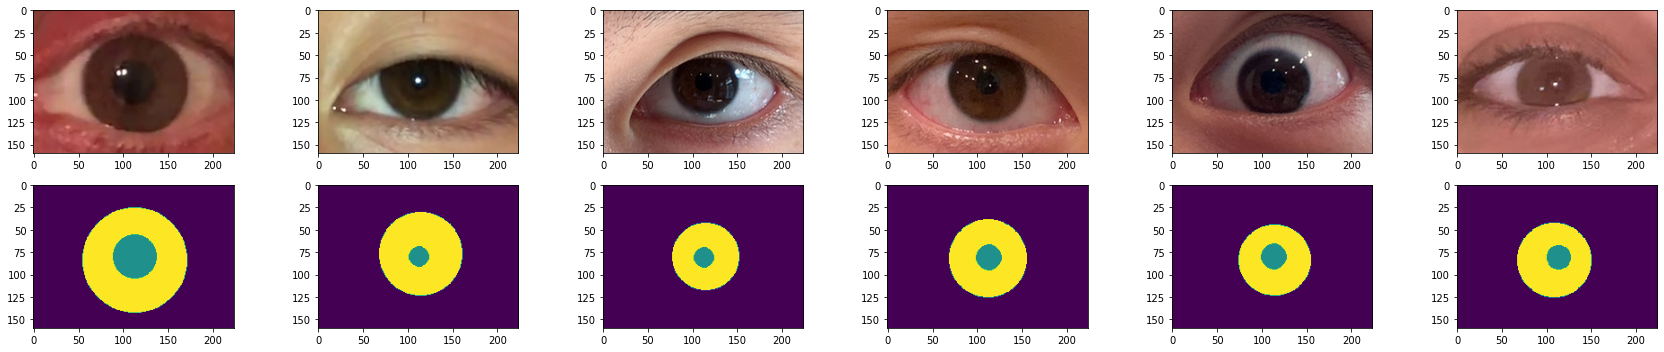

In [ ]:
def plot_random_imgs(data_index: pd.DataFrame, k_imgs:int = 6 ):
    """
    helper function to inspect x, y images
        Parameters:
            data_index (pd.DataFrame): data index dataframe
            k_imgs (int): number of images to plot
    """
    fig, ax = plt.subplots(2, k_imgs, figsize=(4*k_imgs, 5))
    for i in range(k_imgs):
        id = np.random.choice(data_index.index)
        img_x = plt.imread(data_index.loc[id]['x_img-path'])
        img_y = plt.imread(data_index.loc[id]['y_img-path'])
        if i == 0: print(img_x.shape, img_y.shape); print(img_x.max())
        ax[0, i].imshow(img_x)
        ax[1, i].imshow(img_y)
    fig.tight_layout()
plot_random_imgs(data_index)
x_img_size = (160, 224, 3)
y_img_size = (160, 224, 3)

## Data: Dataloader, Augmentation

Data Augmentation

In [ ]:
# Define image data generator and augmentations
def train_valmask_datagen(imgid_dir: Path, 
                          imgid_df: pd.DataFrame, 
                          x_col_name:str = "x-img", 
                          y_col_name:str = "y-img", 
                          img_shape: tuple = (160, 224),
                          batch_size:int = 16):
    """
    Returns Dataframe for input/output data paths
            Parameters:
                imgid_dir: Path : Path to dataset
                imgid_df: pd.DataFrame: dataindex dataframe 
                x_col_name:str = column name for input image x 
                y_col_name:str = column name for target image y
                train_shape: tuple : input image size
                test_shape: tuple : target image size
                batch_size:int : batch size
            Returns:
                generators: List[train generator, val generator, image_generator, val_image_generator]
    """
    imgid_df[[x_col_name, y_col_name]] = imgid_df[[x_col_name, y_col_name]].astype(str)
    # Data augmentation arguments 
    data_gen_args = dict(
        #featurewise_center=True,
        #featurewise_std_normalization=True,
        rotation_range=180,
        width_shift_range=0.2,
        height_shift_range=0.1,
        zoom_range=(0.6,1.4),
        fill_mode='constant',
        horizontal_flip=True,   # Face is symmetric
        validation_split=0.05,
        brightness_range=[0.8, 1.2],     # Brightness uneveness
    )
    # Instantiate Data Generator
    seed = 101
    img_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator()
    # Provide the same seed and keyword arguments to the fit and flow methods

    flow_args = dict(
        dataframe=imgid_df,
        save_format="tif",
        class_mode=None,
        directory=imgid_dir,
        target_size= img_shape,
        seed = seed
    )
    train_image_generator = img_datagen.flow_from_dataframe(
        x_col=x_col_name,
        subset="training",
        color_mode="rgb",
        batch_size=batch_size,
        **flow_args
    )
    train_mask_generator = mask_datagen.flow_from_dataframe(
        x_col= y_col_name,
        subset="training",
        batch_size=batch_size,
        **flow_args
    )
    train_generator = zip(train_image_generator, train_mask_generator)
    
    val_image_generator = img_datagen.flow_from_dataframe(
        x_col= x_col_name,
        subset= "validation",
        color_mode="rgb",
        batch_size= batch_size,
        ** flow_args
    )
    val_mask_generator = mask_datagen.flow_from_dataframe(
        x_col= y_col_name,
        subset="validation",
        batch_size=batch_size,
        ** flow_args
    )
    val_generator = zip(val_image_generator, val_mask_generator)
    print("Train steps/epoch:", train_image_generator.samples//train_image_generator.batch_size)
    print("Val steps/epoch:", val_image_generator.samples//val_image_generator.batch_size)
    return train_generator, val_generator

In [ ]:
# Create image data generator
train_generator, val_generator = train_valmask_datagen(imgid_dir = train_data_fp, 
                                                       imgid_df = pd.read_csv(data_fp/"data_index.csv"), 
                                                       x_col_name = "x_img-path",
                                                       y_col_name = "y_input_img-path",
                                                       img_shape = (SIZE_X,SIZE_Y),
                                                       batch_size = 8)

Found 514 validated image filenames.
Found 541 validated image filenames.
Found 27 validated image filenames.
Found 0 validated image filenames.
Train steps/epoch: 64
Val steps/epoch: 3


In [ ]:
## Visualize some images
def plot_img_augmentations(generator: tf.keras.preprocessing.image.ImageDataGenerator,
                           set_n:int =5 ,
                           class_label:int = 1):
    """
    helper function to inspect augmented x, y images
        Parameters:
            generator (pd.DataFrame): data index dataframe
            k_imgs (int): number of images to plot
            class (int): which class of mask to plot
    """
    ## Set_n: number to plot
    fig, ax = plt.subplots(2, set_n, figsize=(2*set_n,6))
    for n, x in enumerate(generator):
        ax[0,n].imshow(x[0][0].astype(int))  # Top row: image
        ax[1,n].imshow(x[1][0][:,:, class_label])   # Bottom: mask
        if n == set_n-1:
            print(x[0].shape, x[1].shape, x[0].max(), x[1].max(), x[1][0][:,:, class_label])
            print(np.unique(x[1][0].reshape(x[1][0].shape[-1], -1), axis=0).shape)
            break

(8, 160, 224, 3) (8, 160, 224, 3) 255.0 1.0 [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
(3, 35840)


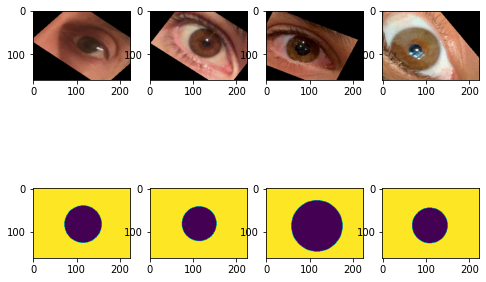

In [ ]:
plot_img_augmentations(train_generator, 4, 0)
# classes: {Iris: 0, Pupil: 1, "background":2}

## Custom Model

In [ ]:
# Look at layer names for VGG for skip connection
print([(layer.name, layer.output_shape) for layer in VGG19(weights='imagenet', include_top=False,input_shape=(160,224,3)).layers])
print([(layer.name, layer.output_shape) for layer in VGG16(weights='imagenet', include_top=False,input_shape=(160,224,3)).layers])

In [ ]:
# @title model Architecture
def squeeze_excite_block(inputs, ratio=8):
    """
    squeeze-and-excite block in the proposed networks reduces the redundant 
    information and passes the most relevant information    
    """
    filters = inputs.shape[-1]  # a filter per input layer 
    
    se = GlobalAveragePooling2D()(inputs)
    se = Reshape((1, 1, filters))(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([inputs, se])
    return x

def conv_block(inputs, filters, kernel_size=(3, 3), dilation=(1,1), use_bias=True):
    """
    regular convolution block
    """
    x = inputs
    x = Conv2D(filters, kernel_size, dilation_rate=dilation, padding="same", 
                kernel_initializer = 'he_normal', use_bias=use_bias)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def conv_block_2x(inputs, filters):
    """
    regular double convolution block followed by squeeze-excitation block
    """
    x = inputs
    x = conv_block(x, filters)
    x = conv_block(x, filters)
    x = squeeze_excite_block(x)
    return x

def encoder1(inputs):
    """
    Encoder block. 
    Use pre-trained encoder (VGG19 or VGG16), and create skip connections for decoder block 1
        Parameters: 
            inputs: layers.Inputs class
            encoder:
    """
    skip_connections = []
    encoder = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)   # Transfer pre-trained VGG16 encoder
    names = ["block1_conv2", "block2_conv2", "block3_conv3", "block4_conv3"]    # Layer with skip connections
    for name in names:
        skip_connections.append(encoder.get_layer(name).output)
    output = encoder.get_layer("block5_conv3").output
    return output, skip_connections

def decoder1(inputs, skip_connections, filters = [256, 128, 64, 32]):
    """
    Decoder block 1 receiving skip connections
        Parameters:
            inputs: inputs from previous layer (encoder2)
            skip_connections: passed from (encoder VGG)
            filters: filters number
    """
    skip_connections.reverse()
    x = inputs
    for i, f in enumerate(filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_connections[i]])
        x = conv_block_2x(x, f)
    return x

def encoder2(inputs, filters = [32, 64, 128, 256]):
    """
    Encoder block 2
        Parameters:
            inputs: receive outputs from left U-net (decoder block)
    """
    skip_connections = []
    x = inputs
    for i, f in enumerate(filters):
        x = conv_block_2x(x, f)
        skip_connections.append(x)
        x = MaxPooling2D((2, 2))(x)
    return x, skip_connections

def decoder2(inputs, skip_1, skip_2, filters=[256, 128, 64, 32]):
    """
    Decoder block 2
        Parameters:
            inputs: receive ouputs from ASPP and skipp connections from 
                    outputs1 and encoder1
    """
    skip_2.reverse()
    x = inputs
    for i, f in enumerate(filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_1[i], skip_2[i]])
        x = conv_block_2x(x, f)
    return x

def output_block(inputs, n_classes):
    """ output block structure
        Paramters:
            inputs from decoder blocks
    """
    x = Conv2D(1, (1, 1),  kernel_initializer = 'he_normal',padding="same")(inputs)
    if n_classes > 2:
        x = Activation('relu')(x)
    else:
        x = Activation('sigmoid')(x)    # Softmax: multiclass
    return x

def ASPP(x, filter):
    """
    Atrous Spatial Pyramid Pooling block
    """
    shape = x.shape
    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = conv_block(y1, filter, 1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation='bilinear')(y1)
    # Serial dilated convolution
    y2 = conv_block(x, filter, 1, 1, use_bias=False)
    y3 = conv_block(x, filter, 3, 6, use_bias=False)
    y4 = conv_block(x, filter, 3, 12, use_bias=False)
    y5 = conv_block(x, filter, 3, 18, use_bias=False)
    
    y = Concatenate()([y1, y2, y3, y4, y5])     # Concatenate outputs
    y = conv_block(y, filter, 1, 1)
    return y

def build_model(input_shape=(160, 224, 3), n_classes=2):
    # U-LEFT
    inputs = Input(input_shape)
    # 1a Encoder & skip connections
    x, skip_1 = encoder1(inputs)
    x = ASPP(x, 64)                     # ASPP feature extraction
    # 2a. Decoder block
    x = decoder1(x, skip_1)
    outputs1 = output_block(x, n_classes)          # Output block
    # U-RIGHT
    x = inputs * outputs1               #  Input Identity link 
    # 1b. Encoder 2
    x, skip_2 = encoder2(x)
    x = ASPP(x, 64)                     # ASPP feature extraction
    # 2b. Decoder 2
    x = decoder2(x, skip_1, skip_2)
    outputs2 = output_block(x, n_classes)          # Output block 2
    outputs = Concatenate()([outputs1, outputs2])   # skip connection
    if n_classes > 2:
        # a pixelwise probability vector sized (batch_size, rows*cols, n_classes)
        outputs = Conv2D(n_classes,1,1,padding='same', activation='softmax')(outputs)
    model = Model(inputs, outputs)
    return model

58900480/58889256 [==============================] - 1s 0us/step
23988011


### losses

In [ ]:
def iou(y_true, y_pred, e=1e-9):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + e) / (union + e)
        return x.astype(np.float32)
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

def dice_coef(y_true, y_pred, e=1e-9):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + e) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + e)

def dice_loss(y_true, y_pred):
    """
    F1 loss
        Parameters:
            y_true: target labels
            y_pred: output logits
    """
    return 1.0 - dice_coef(y_true, y_pred)